# Task 3: Time Series Analysis

This notebook implements time series analysis following the course recommendations from:
- `8_time_series_similarity_2024.pdf`
- `5-data-understanding_ts.pdf`

## Objectives:
1. Create univariate time series for each patient (subject_id)
2. Apply preprocessing transformations (offset removal, scaling, trend removal, noise filtering)
3. Apply approximation methods (PAA) or feature extraction
4. Visualize and analyze the results

## Approach:
- Focus on laboratory values over time (e.g., glucose, troponin)
- Use `charttime` as the timestamp
- Create one time series per patient per measurement type


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set paths - adjust if running from different directory
base_path = Path.cwd()
# If running from code directory, go up one level to find Data folder
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")


Working directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data


## 1. Load Data with Timestamps

Load the raw datasets that contain timestamps for creating time series.


In [2]:
# Load laboratory events (has charttime and numeric values)
df_lab = pd.read_csv(data_path / 'laboratory_events_codes_2.csv')
df_lab['charttime'] = pd.to_datetime(df_lab['charttime'], errors='coerce')

# Load heart diagnoses (has subject_id and charttime for linking)
df_heart = pd.read_csv(data_path / 'heart_diagnoses_1.csv')
df_heart['charttime'] = pd.to_datetime(df_heart['charttime'], errors='coerce')

print(f"Laboratory Events: {len(df_lab):,} rows")
print(f"Heart Diagnoses: {len(df_heart):,} rows")
print(f"\nLaboratory columns: {df_lab.columns.tolist()}")
print(f"\nSample laboratory data:")
df_lab[['hadm_id', 'charttime', 'valuenum', 'label', 'flag']].head(10)


Laboratory Events: 978,503 rows
Heart Diagnoses: 4,864 rows

Laboratory columns: ['hadm_id', 'charttime', 'value', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper', 'flag', 'label', 'fluid', 'examination_group', 'analysis_batch_id', 'qc_flag', 'ref_range']

Sample laboratory data:


,hadm_id,charttime,valuenum,label,flag
0,29654838.0,2188-01-04 23:43:00,198.00,Creatine Kinase (CK),NaN
1,29654838.0,2188-01-04 23:43:00,5.00,"Creatine Kinase, MB Isoenzyme",NaN
2,29654838.0,2188-01-04 23:43:00,0.03,Troponin T,abnormal
3,29654838.0,2188-01-05 06:56:00,1.20,INR(PT),abnormal
4,29654838.0,2188-01-05 06:56:00,12.80,PT,abnormal
5,29654838.0,2188-01-05 06:56:00,85.80,PTT,abnormal
6,29654838.0,2188-01-05 06:56:00,8.10,% Hemoglobin A1c,abnormal
7,29654838.0,2188-01-05 06:56:00,186.00,eAG,abnormal
8,29654838.0,2188-01-05 06:56:00,19.00,Anion Gap,NaN
9,29654838.0,2188-01-05 06:56:00,20.00,Bicarbonate,abnormal


In [3]:
# Add subject_id to laboratory events by merging with heart diagnoses
# Get unique hadm_id -> subject_id mapping
hadm_to_subject = df_heart[['hadm_id', 'subject_id']].drop_duplicates()

# Merge to add subject_id to laboratory events
df_lab = df_lab.merge(hadm_to_subject, on='hadm_id', how='left')

print(f"Laboratory events with subject_id: {df_lab['subject_id'].notna().sum():,} / {len(df_lab):,}")
print(f"Unique subjects in lab data: {df_lab['subject_id'].nunique():,}")
print(f"\nSample after merge:")
df_lab[['subject_id', 'hadm_id', 'charttime', 'valuenum', 'label']].head(10)


Laboratory events with subject_id: 1,000,811 / 1,000,811
Unique subjects in lab data: 4,385

Sample after merge:


,subject_id,hadm_id,charttime,valuenum,label
0,10000980,29654838.0,2188-01-04 23:43:00,198.00,Creatine Kinase (CK)
1,10000980,29654838.0,2188-01-04 23:43:00,5.00,"Creatine Kinase, MB Isoenzyme"
2,10000980,29654838.0,2188-01-04 23:43:00,0.03,Troponin T
3,10000980,29654838.0,2188-01-05 06:56:00,1.20,INR(PT)
4,10000980,29654838.0,2188-01-05 06:56:00,12.80,PT
5,10000980,29654838.0,2188-01-05 06:56:00,85.80,PTT
6,10000980,29654838.0,2188-01-05 06:56:00,8.10,% Hemoglobin A1c
7,10000980,29654838.0,2188-01-05 06:56:00,186.00,eAG
8,10000980,29654838.0,2188-01-05 06:56:00,19.00,Anion Gap
9,10000980,29654838.0,2188-01-05 06:56:00,20.00,Bicarbonate


## 2. Create Univariate Time Series per Patient

Create time series for each patient. We'll focus on common laboratory tests like glucose.


In [4]:
# Filter for valid data
df_lab_clean = df_lab[
    (df_lab['subject_id'].notna()) & 
    (df_lab['charttime'].notna()) & 
    (df_lab['valuenum'].notna()) &
    (df_lab['qc_flag'] == 'OK')  # Only use quality-controlled data
].copy()

print(f"Clean laboratory data: {len(df_lab_clean):,} rows")
print(f"\nMost common lab tests:")
print(df_lab_clean['label'].value_counts().head(10))


Clean laboratory data: 835,692 rows

Most common lab tests:
label
Potassium        34859
Glucose          34209
Chloride         33855
Sodium           33691
Creatinine       33105
Urea Nitrogen    32854
Bicarbonate      32177
Anion Gap        32048
Magnesium        31154
Hemoglobin       28567
Name: count, dtype: int64


In [5]:
# Select a common lab test for time series analysis
# Glucose is a good choice as it's frequently measured
selected_label = 'Glucose'

# Filter for glucose measurements
df_glucose = df_lab_clean[df_lab_clean['label'] == selected_label].copy()

# Sort by subject_id and charttime
df_glucose = df_glucose.sort_values(['subject_id', 'charttime'])

print(f"Glucose measurements: {len(df_glucose):,} rows")
print(f"Unique subjects with glucose data: {df_glucose['subject_id'].nunique():,}")
print(f"\nGlucose value statistics:")
print(df_glucose['valuenum'].describe())


Glucose measurements: 34,209 rows
Unique subjects with glucose data: 4,331

Glucose value statistics:
count    34209.000000
mean       134.528253
std         66.663101
min         21.000000
25%         98.000000
50%        117.000000
75%        150.000000
max       1000.000000
Name: valuenum, dtype: float64


In [6]:
# Create time series for each subject_id
# Group by subject_id and create time series
def create_time_series(group):
    """Create a time series from a group of measurements."""
    ts = group.sort_values('charttime')[['charttime', 'valuenum']].copy()
    ts = ts.reset_index(drop=True)
    return ts

# Group by subject_id and create time series
time_series_dict = {}
for subject_id, group in df_glucose.groupby('subject_id'):
    ts = create_time_series(group)
    if len(ts) >= 3:  # Only keep subjects with at least 3 measurements
        time_series_dict[subject_id] = ts

print(f"Subjects with time series (≥3 measurements): {len(time_series_dict):,}")
print(f"\nExample time series for subject {list(time_series_dict.keys())[0]}:")
print(time_series_dict[list(time_series_dict.keys())[0]].head(10))


Subjects with time series (≥3 measurements): 3,324

Example time series for subject 10000980:
            charttime  valuenum
0 2188-01-05 06:56:00      96.0
1 2188-01-06 09:09:00     138.0
2 2189-06-29 09:15:00     144.0
3 2189-06-29 14:00:00     163.0
4 2189-06-30 11:40:00     160.0
5 2189-07-02 10:20:00      82.0
6 2189-07-03 12:00:00     142.0
7 2189-07-04 12:26:00     121.0


## 3. Preprocessing Time Series

Following course recommendations, apply preprocessing transformations in order:
1. Offset Translation Removal
2. Amplitude Scaling
3. Linear Trend Removal (if needed)
4. Noise Filtering (if needed)


In [7]:
def preprocess_time_series(ts_values, apply_trend_removal=True, apply_noise_filtering=True, window_size=3):
    """
    Preprocess time series following course recommendations.
    
    Steps:
    1. Offset Translation: Q = Q - mean(Q)
    2. Amplitude Scaling: Q = (Q - mean(Q)) / std(Q)
    3. Linear Trend Removal: Fit line and subtract
    4. Noise Filtering: Moving average smoothing
    """
    values = ts_values.copy()
    original_values = values.copy()
    
    # Step 1: Offset Translation Removal
    mean_val = np.mean(values)
    values_step1 = values - mean_val
    
    # Step 2: Amplitude Scaling
    std_val = np.std(values)
    if std_val > 0:
        values_step2 = values_step1 / std_val
    else:
        values_step2 = values_step1
    
    # Step 3: Linear Trend Removal
    if apply_trend_removal and len(values) > 2:
        x = np.arange(len(values))
        slope, intercept = np.polyfit(x, values_step2, 1)
        trend = slope * x + intercept
        values_step3 = values_step2 - trend
    else:
        values_step3 = values_step2
        trend = None
    
    # Step 4: Noise Filtering (Moving Average)
    if apply_noise_filtering and len(values) >= window_size:
        values_step4 = np.convolve(values_step3, np.ones(window_size)/window_size, mode='same')
        # Handle edges
        half_window = window_size // 2
        values_step4[:half_window] = values_step3[:half_window]
        values_step4[-half_window:] = values_step3[-half_window:]
    else:
        values_step4 = values_step3
    
    return {
        'original': original_values,
        'after_offset': values_step1,
        'after_scaling': values_step2,
        'after_trend': values_step3,
        'after_noise_filter': values_step4,
        'trend': trend if apply_trend_removal else None
    }

# Test preprocessing on a sample time series
sample_subject = list(time_series_dict.keys())[0]
sample_ts = time_series_dict[sample_subject]
preprocessed = preprocess_time_series(sample_ts['valuenum'].values)

print(f"Preprocessing example for subject {sample_subject}:")
print(f"Original mean: {preprocessed['original'].mean():.2f}, std: {preprocessed['original'].std():.2f}")
print(f"After scaling mean: {preprocessed['after_scaling'].mean():.2f}, std: {preprocessed['after_scaling'].std():.2f}")


Preprocessing example for subject 10000980:
Original mean: 130.75, std: 27.22
After scaling mean: 0.00, std: 1.00


In [8]:
# Apply preprocessing to all time series
preprocessed_series = {}
for subject_id, ts in time_series_dict.items():
    preprocessed = preprocess_time_series(ts['valuenum'].values)
    preprocessed_series[subject_id] = {
        'timestamps': ts['charttime'].values,
        'original': ts['valuenum'].values,
        'preprocessed': preprocessed['after_noise_filter'],
        'all_steps': preprocessed
    }

print(f"Preprocessed {len(preprocessed_series):,} time series")


Preprocessed 3,324 time series


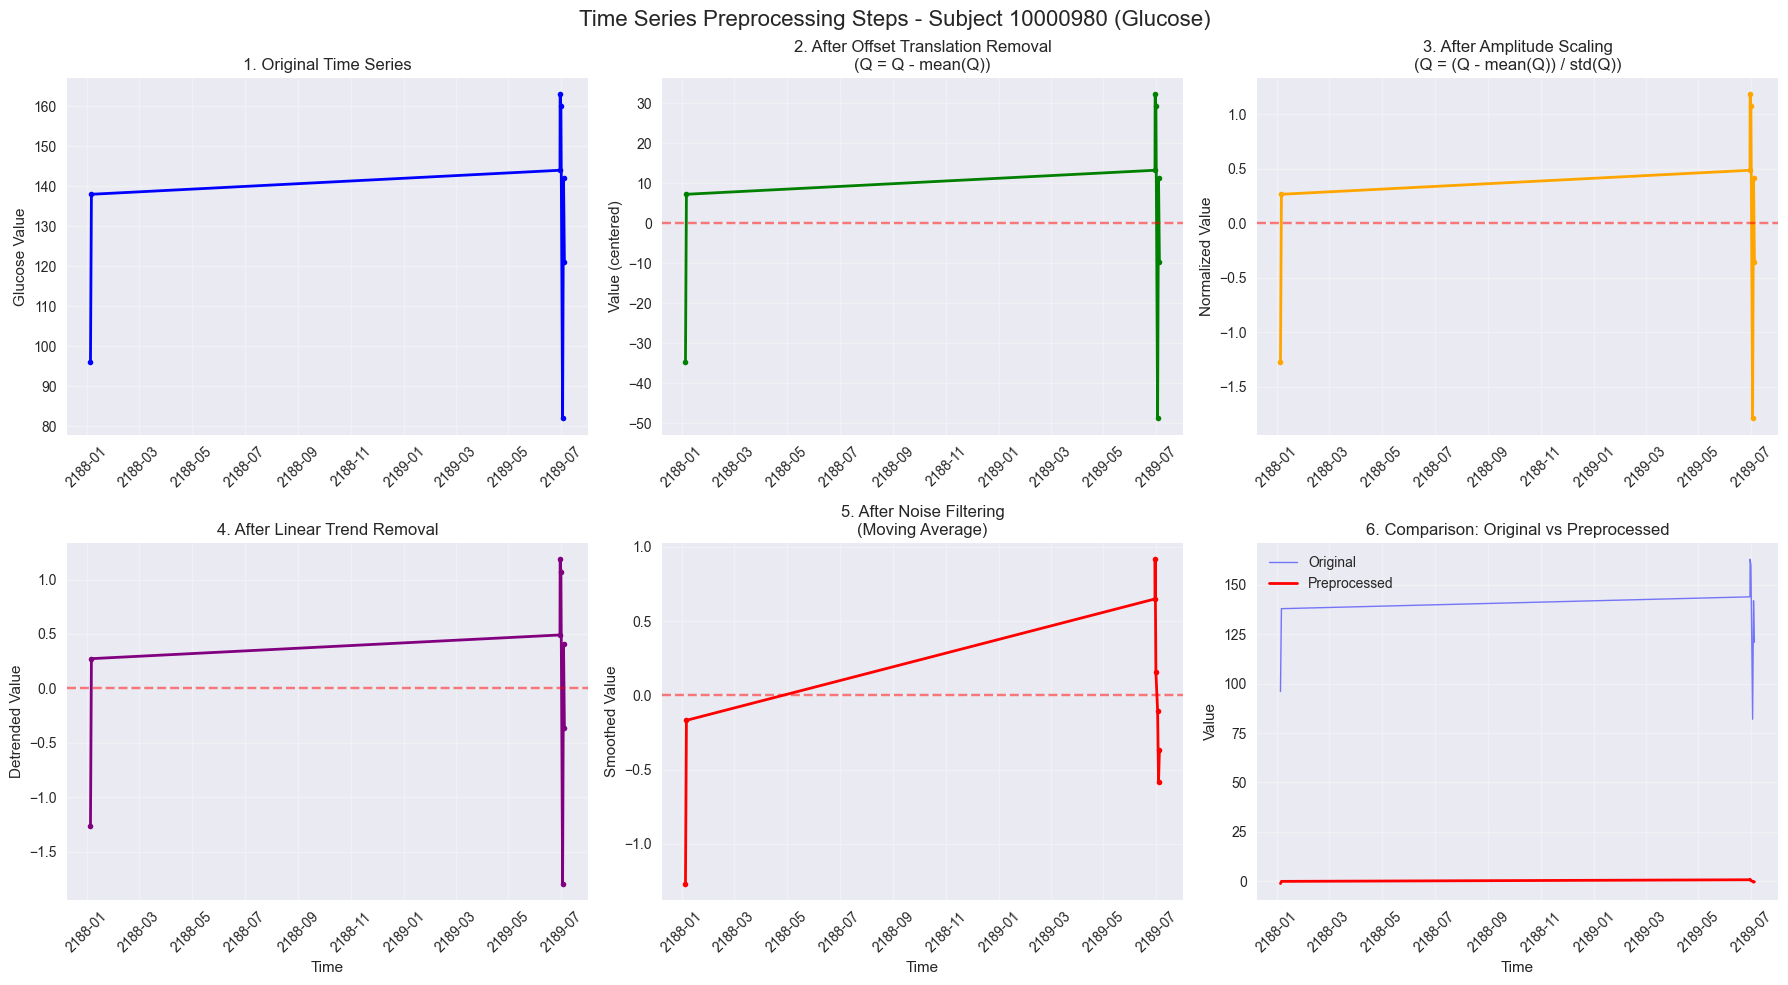

In [9]:
# Visualize preprocessing steps for a sample subject
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Time Series Preprocessing Steps - Subject {sample_subject} (Glucose)', fontsize=16)

sample_data = preprocessed_series[sample_subject]
steps = sample_data['all_steps']
timestamps = sample_data['timestamps']

# Plot original
axes[0, 0].plot(timestamps, steps['original'], 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].set_title('1. Original Time Series')
axes[0, 0].set_ylabel('Glucose Value')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot after offset removal
axes[0, 1].plot(timestamps, steps['after_offset'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('2. After Offset Translation Removal\n(Q = Q - mean(Q))')
axes[0, 1].set_ylabel('Value (centered)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot after scaling
axes[0, 2].plot(timestamps, steps['after_scaling'], 'orange', linewidth=2, marker='o', markersize=4)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 2].set_title('3. After Amplitude Scaling\n(Q = (Q - mean(Q)) / std(Q))')
axes[0, 2].set_ylabel('Normalized Value')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot after trend removal
axes[1, 0].plot(timestamps, steps['after_trend'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('4. After Linear Trend Removal')
axes[1, 0].set_ylabel('Detrended Value')
axes[1, 0].set_xlabel('Time')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot after noise filtering
axes[1, 1].plot(timestamps, steps['after_noise_filter'], 'red', linewidth=2, marker='o', markersize=4)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('5. After Noise Filtering\n(Moving Average)')
axes[1, 1].set_ylabel('Smoothed Value')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot comparison: original vs final
axes[1, 2].plot(timestamps, steps['original'], 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 2].plot(timestamps, steps['after_noise_filter'], 'r-', linewidth=2, label='Preprocessed')
axes[1, 2].set_title('6. Comparison: Original vs Preprocessed')
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_xlabel('Time')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_preprocessing_steps.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
def paa_transform(ts_values, num_segments):
    """
    Piecewise Aggregate Approximation (PAA).
    
    Divides time series into w equal-sized segments and replaces
    values in each segment with their average.
    
    Parameters:
    - ts_values: array of time series values
    - num_segments: number of segments (w)
    
    Returns:
    - paa_values: approximated time series
    - segment_indices: indices where segments start
    """
    n = len(ts_values)
    if num_segments >= n:
        return ts_values, np.arange(n)
    
    segment_size = n / num_segments
    paa_values = []
    segment_indices = [0]
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > n:
            end_idx = n
        
        # Average of segment
        segment_mean = np.mean(ts_values[start_idx:end_idx])
        paa_values.append(segment_mean)
        
        if i < num_segments - 1:
            segment_indices.append(end_idx)
    
    return np.array(paa_values), np.array(segment_indices)

# Test PAA on sample time series
sample_values = preprocessed_series[sample_subject]['preprocessed']
paa_result, segment_idx = paa_transform(sample_values, num_segments=5)

print(f"Original length: {len(sample_values)}")
print(f"PAA length: {len(paa_result)}")
print(f"PAA values: {paa_result}")
print(f"Compression ratio: {len(sample_values) / len(paa_result):.2f}x")


Original length: 8
PAA length: 5
PAA values: [-1.26722885  0.24093965  0.91653267  0.02492479 -0.47619469]
Compression ratio: 1.60x


In [11]:
# Apply PAA to all preprocessed time series
# Use adaptive number of segments based on series length
paa_results = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    # Use approximately 1/3 of original length, but at least 3 and at most 10
    num_segments = max(3, min(10, len(ts_values) // 3))
    paa_values, segment_idx = paa_transform(ts_values, num_segments)
    paa_results[subject_id] = {
        'paa_values': paa_values,
        'num_segments': num_segments,
        'original_length': len(ts_values)
    }

print(f"Applied PAA to {len(paa_results):,} time series")
print(f"\nExample PAA result for subject {sample_subject}:")
print(f"Original length: {paa_results[sample_subject]['original_length']}")
print(f"PAA segments: {paa_results[sample_subject]['num_segments']}")
print(f"PAA values: {paa_results[sample_subject]['paa_values']}")


Applied PAA to 3,324 time series

Example PAA result for subject 10000980:
Original length: 8
PAA segments: 3
PAA values: [-0.71757162  0.57370747 -0.35244529]


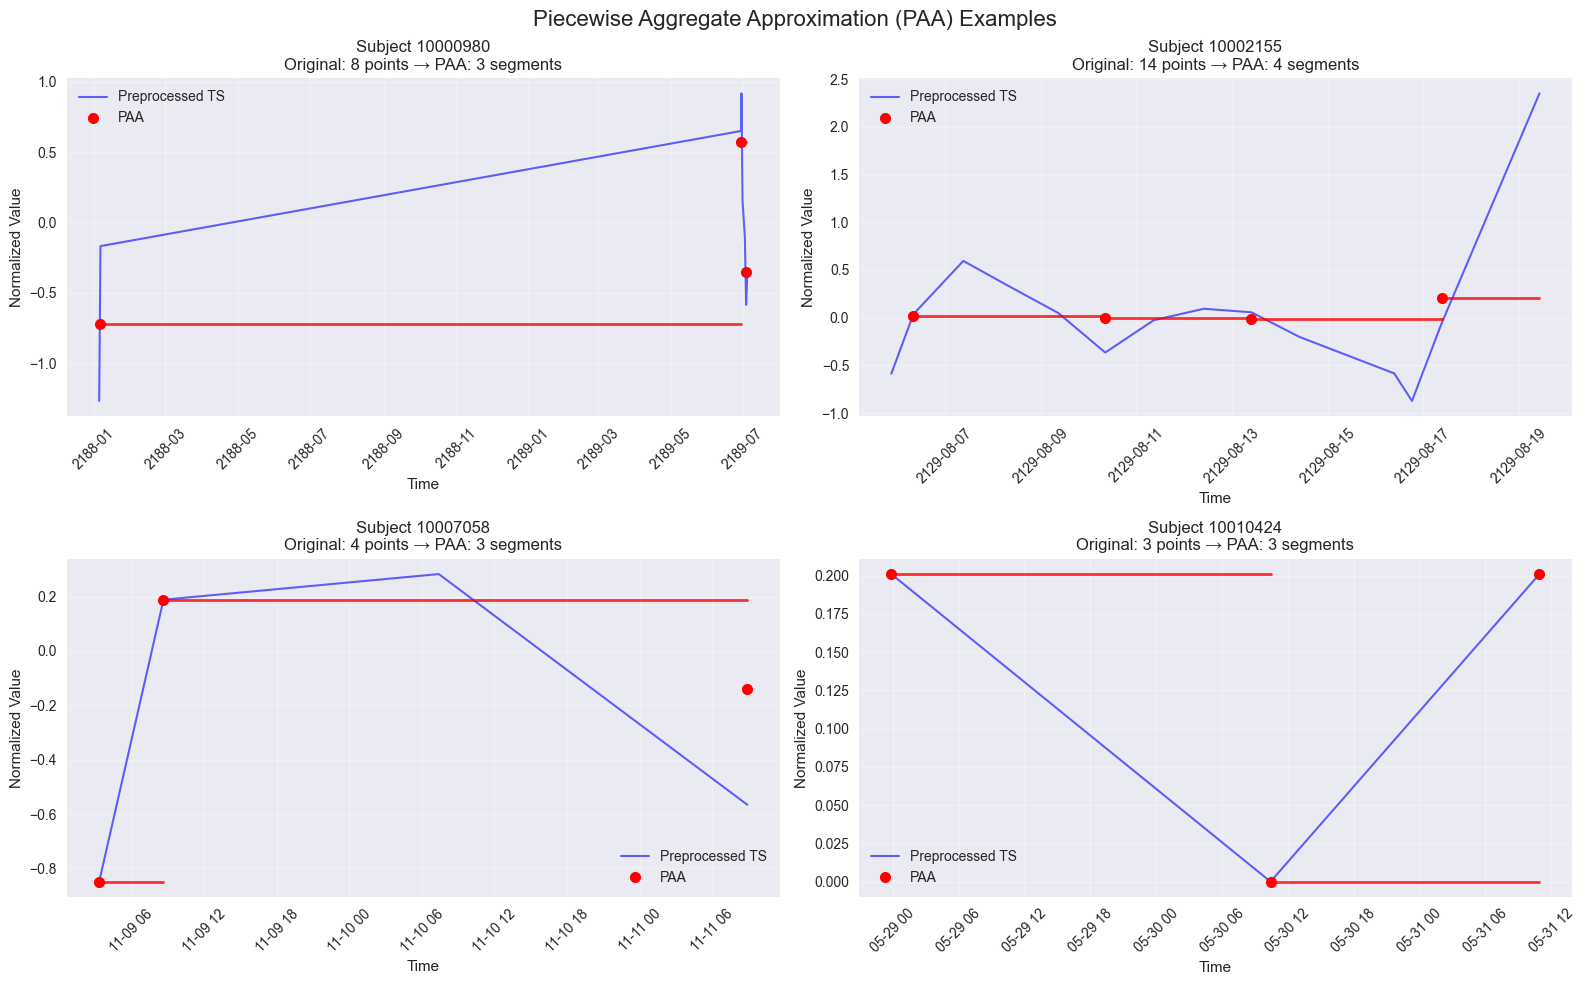

In [12]:
# Visualize PAA approximation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Piecewise Aggregate Approximation (PAA) Examples', fontsize=16)

# Select a few subjects to visualize
subjects_to_plot = list(preprocessed_series.keys())[:4]

for idx, subject_id in enumerate(subjects_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    data = preprocessed_series[subject_id]
    timestamps = data['timestamps']
    original = data['preprocessed']
    
    # Get PAA result
    paa_vals = paa_results[subject_id]['paa_values']
    num_segments = paa_results[subject_id]['num_segments']
    
    # Reconstruct PAA time series for visualization
    segment_size = len(original) / num_segments
    paa_timestamps = []
    paa_reconstructed = []
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > len(original):
            end_idx = len(original)
        
        # Use midpoint timestamp of segment
        mid_idx = (start_idx + end_idx) // 2
        paa_timestamps.append(timestamps[mid_idx])
        paa_reconstructed.append(paa_vals[i])
    
    # Plot original
    ax.plot(timestamps, original, 'b-', linewidth=1.5, alpha=0.6, label='Preprocessed TS')
    
    # Plot PAA approximation (step function)
    paa_timestamps = np.array(paa_timestamps)
    paa_reconstructed = np.array(paa_reconstructed)
    
    # Create step plot for PAA
    for i in range(len(paa_reconstructed) - 1):
        start_time = paa_timestamps[i]
        end_time = paa_timestamps[i + 1]
        ax.plot([start_time, end_time], [paa_reconstructed[i], paa_reconstructed[i]], 
                'r-', linewidth=2, alpha=0.8)
        if i == 0:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8, label='PAA')
        else:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8)
    
    # Plot last segment
    if len(paa_reconstructed) > 0:
        last_time = timestamps[-1]
        ax.plot([paa_timestamps[-1], last_time], 
                [paa_reconstructed[-1], paa_reconstructed[-1]], 
                'r-', linewidth=2, alpha=0.8)
        ax.plot([paa_timestamps[-1]], [paa_reconstructed[-1]], 'ro', markersize=8)
    
    ax.set_title(f'Subject {subject_id}\nOriginal: {len(original)} points → PAA: {num_segments} segments')
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_paa_approximation.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Feature Extraction

Extract statistical features from the preprocessed time series as an alternative/complementary approach.


In [13]:
def extract_time_series_features(ts_values):
    """
    Extract statistical features from time series.
    
    Features:
    - Mean, Variance, Std
    - Min, Max, Range
    - Trend (slope of linear fit)
    - Auto-covariance (lag-1)
    - Rolling statistics (if applicable)
    """
    features = {}
    
    # Basic statistics
    features['mean'] = np.mean(ts_values)
    features['variance'] = np.var(ts_values)
    features['std'] = np.std(ts_values)
    features['min'] = np.min(ts_values)
    features['max'] = np.max(ts_values)
    features['range'] = features['max'] - features['min']
    features['median'] = np.median(ts_values)
    
    # Trend (slope of linear fit)
    if len(ts_values) > 1:
        x = np.arange(len(ts_values))
        slope, intercept = np.polyfit(x, ts_values, 1)
        features['trend_slope'] = slope
        features['trend_intercept'] = intercept
    else:
        features['trend_slope'] = 0
        features['trend_intercept'] = ts_values[0] if len(ts_values) > 0 else 0
    
    # Auto-covariance (lag-1)
    if len(ts_values) > 1:
        features['autocov_lag1'] = np.cov(ts_values[:-1], ts_values[1:])[0, 1]
    else:
        features['autocov_lag1'] = 0
    
    # Percentiles
    features['q25'] = np.percentile(ts_values, 25)
    features['q75'] = np.percentile(ts_values, 75)
    features['iqr'] = features['q75'] - features['q25']
    
    return features

# Extract features from all preprocessed time series
ts_features = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    features = extract_time_series_features(ts_values)
    ts_features[subject_id] = features

# Convert to DataFrame for easier analysis
features_df = pd.DataFrame.from_dict(ts_features, orient='index')
features_df.index.name = 'subject_id'

print(f"Extracted features from {len(ts_features):,} time series")
print(f"\nFeature statistics:")
print(features_df.describe())


Extracted features from 3,324 time series

Feature statistics:
              mean      variance           std           min           max  \
count  3324.000000  3.324000e+03  3.324000e+03  3.324000e+03  3.324000e+03   
mean     -0.001990  2.389315e-01  4.485357e-01 -6.859902e-01  7.540023e-01   
std       0.164284  1.761085e-01  1.943157e-01  4.315644e-01  5.472163e-01   
min      -0.471405  3.286920e-32  1.812987e-16 -3.242580e+00 -1.415534e-15   
25%      -0.064880  1.018469e-01  3.191347e-01 -9.636492e-01  3.535534e-01   
50%       0.001871  2.077477e-01  4.557934e-01 -6.943651e-01  6.734332e-01   
75%       0.074804  3.502313e-01  5.918035e-01 -3.609689e-01  1.033933e+00   
max       0.471405  9.272509e-01  9.629387e-01  1.283695e-15  4.739503e+00   

              range       median   trend_slope  trend_intercept  autocov_lag1  \
count  3.324000e+03  3324.000000  3.324000e+03      3324.000000   3324.000000   
mean   1.439993e+00    -0.018967 -1.427951e-03         0.004065      0.0

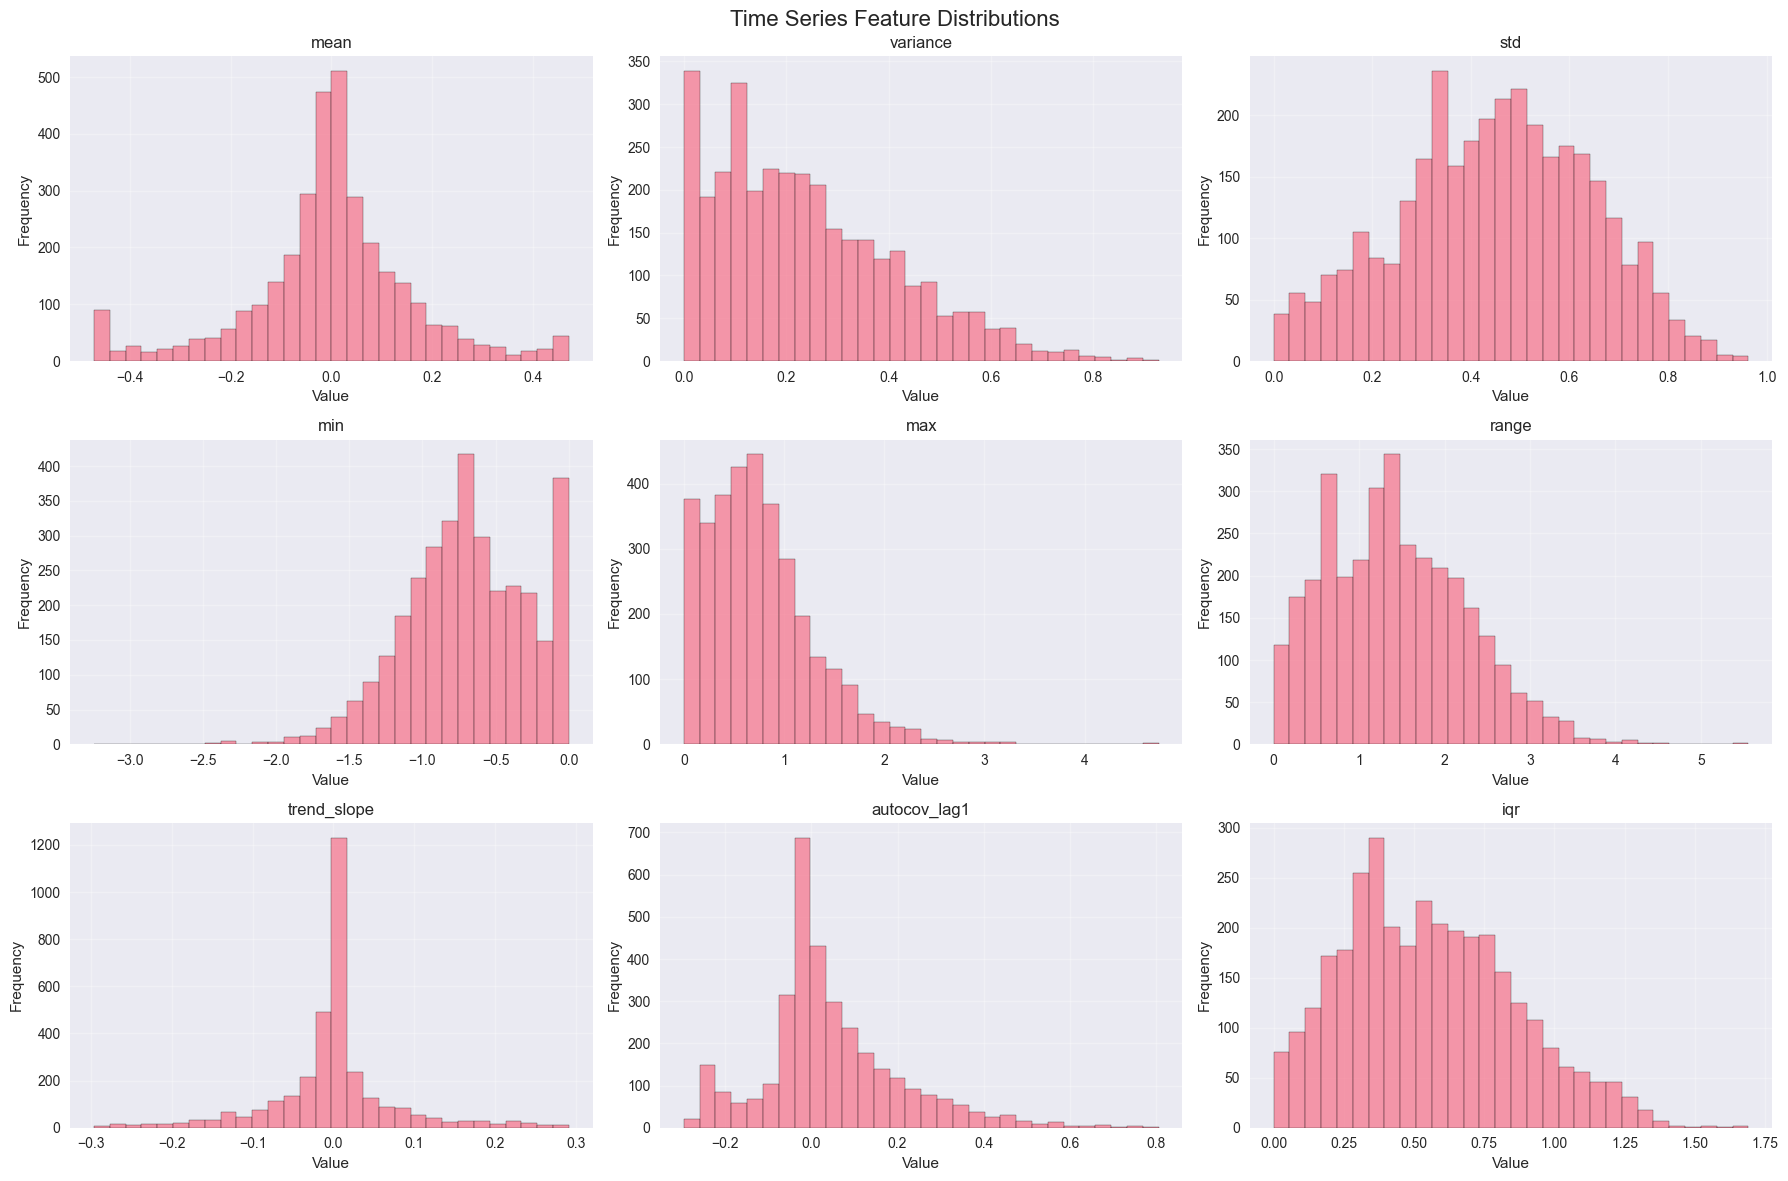

In [14]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Time Series Feature Distributions', fontsize=16)

feature_cols = ['mean', 'variance', 'std', 'min', 'max', 'range', 'trend_slope', 'autocov_lag1', 'iqr']
for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(features_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(code_path / 'time_series_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Summary statistics
print("="*60)
print("TIME SERIES ANALYSIS SUMMARY")
print("="*60)
print(f"\n1. Data Overview:")
print(f"   - Laboratory test analyzed: {selected_label}")
print(f"   - Total measurements: {len(df_glucose):,}")
print(f"   - Unique subjects: {df_glucose['subject_id'].nunique():,}")
print(f"   - Subjects with time series (≥3 measurements): {len(time_series_dict):,}")

print(f"\n2. Preprocessing:")
print(f"   - Applied offset translation removal")
print(f"   - Applied amplitude scaling (z-normalization)")
print(f"   - Applied linear trend removal")
print(f"   - Applied noise filtering (moving average)")

print(f"\n3. Approximation (PAA):")
avg_compression = np.mean([r['original_length'] / r['num_segments'] 
                           for r in paa_results.values()])
print(f"   - Average compression ratio: {avg_compression:.2f}x")
print(f"   - Average segments per series: {np.mean([r['num_segments'] for r in paa_results.values()]):.1f}")

print(f"\n4. Feature Extraction:")
print(f"   - Number of features extracted: {len(features_df.columns)}")
print(f"   - Features: {', '.join(features_df.columns.tolist())}")

print(f"\n5. Time Series Length Statistics:")
ts_lengths = [len(data['preprocessed']) for data in preprocessed_series.values()]
print(f"   - Mean length: {np.mean(ts_lengths):.1f} measurements")
print(f"   - Median length: {np.median(ts_lengths):.1f} measurements")
print(f"   - Min length: {np.min(ts_lengths)} measurements")
print(f"   - Max length: {np.max(ts_lengths)} measurements")

print("\n" + "="*60)


TIME SERIES ANALYSIS SUMMARY

1. Data Overview:
   - Laboratory test analyzed: Glucose
   - Total measurements: 34,209
   - Unique subjects: 4,331
   - Subjects with time series (≥3 measurements): 3,324

2. Preprocessing:
   - Applied offset translation removal
   - Applied amplitude scaling (z-normalization)
   - Applied linear trend removal
   - Applied noise filtering (moving average)

3. Approximation (PAA):
   - Average compression ratio: 2.30x
   - Average segments per series: 3.8

4. Feature Extraction:
   - Number of features extracted: 13
   - Features: mean, variance, std, min, max, range, median, trend_slope, trend_intercept, autocov_lag1, q25, q75, iqr

5. Time Series Length Statistics:
   - Mean length: 9.8 measurements
   - Median length: 7.0 measurements
   - Min length: 3 measurements
   - Max length: 142 measurements



In [16]:
# Save results
output_path = data_path / '3.1_time_series_features.csv'
features_df.to_csv(output_path)
print(f"Saved time series features to: {output_path}")

# Save PAA results summary
paa_summary = pd.DataFrame({
    'subject_id': list(paa_results.keys()),
    'original_length': [r['original_length'] for r in paa_results.values()],
    'paa_segments': [r['num_segments'] for r in paa_results.values()],
    'compression_ratio': [r['original_length'] / r['num_segments'] for r in paa_results.values()]
})
paa_output_path = data_path / '3.1_time_series_paa_summary.csv'
paa_summary.to_csv(paa_output_path, index=False)
print(f"Saved PAA summary to: {paa_output_path}")

print("\n✓ Time series analysis complete!")


Saved time series features to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/3.1_time_series_features.csv
Saved PAA summary to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/3.1_time_series_paa_summary.csv

✓ Time series analysis complete!
